- Team Notion url : 
https://www.notion.so/831dba3b320a45dcb2acb570c251bac6

- Target : Make a model for prediction

# Import Python Libraries

In [1]:
from google.colab import drive
root_dir = '/content/drive/'
drive.mount(root_dir)

Mounted at /content/drive/


In [2]:
%matplotlib inline
%cd drive/MyDrive/데이콘_서울시민데이터_경진대회

/content/drive/MyDrive/데이콘_서울시민데이터_경진대회


In [3]:
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.nn as nn
from torchvision import transforms

!pip install torchmetrics
from torchmetrics import F1Score

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from tqdm import tqdm
import copy

import os
import os.path as osp
from pathlib import Path

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 35.6 MB/s 


# 데이터셋 개요
1. Input
- 기상학적 요인: AWS 피쳐들 (년도별, 우선 서울시 전체)
- 지형학적 요인: 지역구 {면적, 산림 면적, 하천 개수}
- 사회경제적 요인: 지역구 {맨홀, 빗물받이}
<br><br>
2. Output
- 피해규모: 지역구 이재민 피해현황 (년도별)

In [ ]:
path_dataset = "dataset/exp2"
X = []
for filename in os.listdir(path_dataset):
  X.append(osp.join(path_dataset, filename))
print(len(X))

463


- Dataset split ~ Train / Validation



In [ ]:
X_train, X_val = train_test_split(X, test_size=0.3, random_state=2022)

# Basic utilities


1. [클래스] Custom Dataset

In [ ]:
def _to_float_tensor(L: list):
  temp = []
  for word in L:
    temp.append(float(word))
  return torch.tensor(temp)

class CustomDataset(Dataset):
  def __init__(self, file_list, transform=None):
    self.file_list = file_list
    self.transform = transform

  def __getitem__(self, i):
    with open(self.file_list[i], "r") as f:
      line = f.readlines()[0].split("\t")
    
    label = torch.tensor(int(line[0]))        
    aws = _to_float_tensor(line[1:12])
    geo = _to_float_tensor(line[12:15])
    social = _to_float_tensor(line[15:])
    
    sample = {'label': label,
              'aws': aws,
              'geo': geo,
              'social': social,
              'file_name': self.file_list[i]}
    return sample
      
  def __len__(self):
    return len(self.file_list)


batch_size = 32
# Dataset
train_dataset = CustomDataset(file_list=X_train)
val_dataset = CustomDataset(file_list=X_val)
# Dataloader
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               num_workers=6,
                                               pin_memory=True,)
val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset,
                                             batch_size=batch_size,
                                             shuffle=False,
                                             num_workers=6,
                                             pin_memory=True,)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


2. [클래스] Basic Network

In [4]:
class Net(nn.Module):
  def __init__(self, dims_list=[11, 32], out_dim=4):
    super(Net, self).__init__()
    
    fc_list = []
    for i in range(len(dims_list)-1):
      fc_list.append(nn.Linear(dims_list[i], dims_list[i+1]))
    fc_list.append(nn.Linear(dims_list[-1], out_dim))
    
    self.fc_list = nn.ModuleList(fc_list)
    self.relu = nn.ReLU()

  def forward(self, x):
    out = x
    for i in range(len(self.fc_list)-1):
      out = self.fc_list[i](out)
      out = self.relu(out)
    out = self.fc_list[-1](out)

    return out

3. [클래스] Focal Loss for imbalanced data

In [ ]:
class FocalLoss(nn.Module): # for imbalanced data
  def __init__(self, alpha=1, gamma=2, logits=False, reduction='sum'):
    super(FocalLoss, self).__init__()
    self.alpha = alpha
    self.gamma = gamma
    self.reduction = reduction
    
    if logits:
      raise ValueError 

  def forward(self, inputs, targets):    
    ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)

    pt = torch.exp(-ce_loss)
    F_loss = self.alpha * (1-pt)**self.gamma * ce_loss

    if self.reduction == 'sum':
      return torch.sum(F_loss)
    else:
      return F_loss

# Case 3 : 기상,지형,사회경제 데이터를 한꺼번에 사용하는 모델

1. [함수] 학습 코드

In [ ]:
def train3(model, Loss, optimizer, num_epochs, save_name=False):
  model = model.to(device)
  f1 = F1Score(num_classes=4)

  loss_dict = {"train_loss":[], "val_loss":[],
               "train_acc":[], "val_acc":[]}
  eval_every = 1
  
  best_test_acc = 0.
  #best_test_loss = np.inf
  early_stop, early_stop_max = 0., 50

  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=10, verbose=True)
  
  for epoch in range(num_epochs):

    epoch_loss = 0.
    epoch_acc = 0.
    for batch_X in tqdm(train_dataloader):
      aws = batch_X['aws'].to(device)
      geo = batch_X['geo'].to(device)
      social = batch_X['social'].to(device)
      inputs = torch.cat((aws,geo,social), -1)
      labels = batch_X['label'].to(device)

      
      optimizer.zero_grad()
      model.train()

      # Forward Pass      
      outputs = model(inputs)
      train_loss = Loss(outputs, labels)
      epoch_loss += train_loss.item()
      epoch_acc += torch.sum(torch.argmax(outputs, -1) == labels)

      # Backward and optimize
      train_loss.backward()
      optimizer.step()

    epoch_loss /= len(train_dataloader.dataset)
    epoch_acc /= len(train_dataloader.dataset)
    loss_dict["train_loss"].append(epoch_loss)
    loss_dict["train_acc"].append(epoch_acc)

    if epoch % eval_every == 0:
      model.eval()

      test_loss = 0.
      test_acc = 0.
      for batch_X in tqdm(val_dataloader):
        aws = batch_X['aws'].to(device)
        geo = batch_X['geo'].to(device)
        social = batch_X['social'].to(device)
        inputs = torch.cat((aws,geo,social), -1)
        labels = batch_X['label'].to(device)

        # Forward Pass
        outputs = model(inputs)
        batch_loss = Loss(outputs, labels)
        test_loss += batch_loss.item()
        test_acc += torch.sum(torch.argmax(outputs, -1) == labels)

      test_loss /= len(val_dataloader.dataset)
      test_acc /= len(val_dataloader.dataset)
      loss_dict["val_loss"].append(test_loss)
      loss_dict["val_acc"].append(test_acc)
      
      
      # scheduler
      scheduler.step(test_loss)

      
      if best_test_acc < test_acc:
        best_test_acc = test_acc
        early_stop = 0
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.8f}, Test Loss: {test_loss:.8f} *')
        best_model = copy.deepcopy(model)
        if save_name:
          torch.save(model.state_dict(), save_name)
      else:
        early_stop += 1
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.8f}, Test Loss: {test_loss:.8f}')
      print(f'\t\t Train acc: {epoch_acc:.8f}, Test acc: {test_acc:.8f}')
      

    if early_stop >= early_stop_max:
      break
    
  return loss_dict, best_model

2. [클래스] 모델 정의 및 학습 진행

100%|██████████| 5/5 [00:00<00:00, 12.75it/s]


Epoch [1/200], Train Loss: 3470.85149619, Test Loss: 2918.03189636 *
		 Train acc: 0.12345679, Test acc: 0.13669065


100%|██████████| 5/5 [00:00<00:00, 13.22it/s]


Epoch [2/200], Train Loss: 2885.68888949, Test Loss: 2517.28044908
		 Train acc: 0.12654321, Test acc: 0.12949640


100%|██████████| 5/5 [00:00<00:00, 12.17it/s]


Epoch [3/200], Train Loss: 2464.44276560, Test Loss: 2117.60732352
		 Train acc: 0.15123457, Test acc: 0.12949640


100%|██████████| 5/5 [00:00<00:00, 11.86it/s]


Epoch [4/200], Train Loss: 2037.69275957, Test Loss: 1734.01031362
		 Train acc: 0.13888890, Test acc: 0.13669065


100%|██████████| 5/5 [00:00<00:00,  7.69it/s]


Epoch [5/200], Train Loss: 1633.83985844, Test Loss: 1343.51999494
		 Train acc: 0.15123457, Test acc: 0.12949640


100%|██████████| 5/5 [00:00<00:00, 13.07it/s]


Epoch [6/200], Train Loss: 1227.65511369, Test Loss: 1057.33801006
		 Train acc: 0.17283951, Test acc: 0.12230216


100%|██████████| 5/5 [00:00<00:00, 13.17it/s]


Epoch [7/200], Train Loss: 939.66686710, Test Loss: 745.60327675
		 Train acc: 0.17901234, Test acc: 0.11510792


100%|██████████| 5/5 [00:00<00:00, 13.22it/s]


Epoch [8/200], Train Loss: 638.34451897, Test Loss: 459.35647342
		 Train acc: 0.17283951, Test acc: 0.12949640


100%|██████████| 5/5 [00:00<00:00, 12.31it/s]


Epoch [9/200], Train Loss: 357.28221677, Test Loss: 175.30479903
		 Train acc: 0.16666667, Test acc: 0.13669065


100%|██████████| 5/5 [00:00<00:00, 11.71it/s]


Epoch [10/200], Train Loss: 107.32450085, Test Loss: 94.59986581 *
		 Train acc: 0.28086421, Test acc: 0.51079136


100%|██████████| 5/5 [00:00<00:00, 13.98it/s]


Epoch [11/200], Train Loss: 97.74053823, Test Loss: 81.08176252
		 Train acc: 0.50308645, Test acc: 0.46762589


100%|██████████| 5/5 [00:00<00:00, 12.32it/s]


Epoch [12/200], Train Loss: 64.29654887, Test Loss: 60.88059855
		 Train acc: 0.42592594, Test acc: 0.35251799


100%|██████████| 5/5 [00:00<00:00, 11.09it/s]


Epoch [13/200], Train Loss: 55.08427580, Test Loss: 50.06481934
		 Train acc: 0.37037036, Test acc: 0.43165466


100%|██████████| 5/5 [00:00<00:00, 11.51it/s]


Epoch [14/200], Train Loss: 51.30352972, Test Loss: 47.80378383
		 Train acc: 0.45679012, Test acc: 0.44604316


100%|██████████| 5/5 [00:00<00:00, 11.86it/s]


Epoch [15/200], Train Loss: 43.77025731, Test Loss: 44.93356301
		 Train acc: 0.43518519, Test acc: 0.38848922


100%|██████████| 5/5 [00:00<00:00, 13.57it/s]


Epoch [16/200], Train Loss: 40.11862854, Test Loss: 38.95233286
		 Train acc: 0.40432099, Test acc: 0.42446044


100%|██████████| 5/5 [00:00<00:00, 13.56it/s]


Epoch [17/200], Train Loss: 37.46153834, Test Loss: 37.74340820
		 Train acc: 0.43209878, Test acc: 0.44604316


100%|██████████| 5/5 [00:00<00:00, 13.55it/s]


Epoch [18/200], Train Loss: 34.61651144, Test Loss: 31.25156232
		 Train acc: 0.42592594, Test acc: 0.43884891


100%|██████████| 5/5 [00:00<00:00, 12.98it/s]


Epoch [19/200], Train Loss: 30.49305832, Test Loss: 28.45687998
		 Train acc: 0.42283949, Test acc: 0.41007194


100%|██████████| 5/5 [00:00<00:00,  7.74it/s]


Epoch [20/200], Train Loss: 27.21706250, Test Loss: 25.65117684
		 Train acc: 0.45061728, Test acc: 0.44604316


100%|██████████| 5/5 [00:00<00:00,  6.97it/s]


Epoch [21/200], Train Loss: 24.91670265, Test Loss: 24.87226132
		 Train acc: 0.41666666, Test acc: 0.48920864


100%|██████████| 5/5 [00:00<00:00,  7.22it/s]


Epoch [22/200], Train Loss: 22.41941980, Test Loss: 22.59249527
		 Train acc: 0.46604937, Test acc: 0.40287769


100%|██████████| 5/5 [00:00<00:00,  7.30it/s]


Epoch [23/200], Train Loss: 21.41718007, Test Loss: 20.17884925
		 Train acc: 0.44135803, Test acc: 0.45323741


100%|██████████| 5/5 [00:00<00:00,  9.66it/s]


Epoch [24/200], Train Loss: 19.02173907, Test Loss: 20.30559886
		 Train acc: 0.42901236, Test acc: 0.43884891


100%|██████████| 5/5 [00:00<00:00,  6.79it/s]


Epoch [25/200], Train Loss: 17.84558749, Test Loss: 17.91922502
		 Train acc: 0.44753087, Test acc: 0.41007194


100%|██████████| 5/5 [00:00<00:00, 13.67it/s]


Epoch [26/200], Train Loss: 16.99463409, Test Loss: 17.65619841
		 Train acc: 0.45987654, Test acc: 0.43165466


100%|██████████| 5/5 [00:00<00:00, 13.70it/s]


Epoch [27/200], Train Loss: 16.25059928, Test Loss: 18.62568785
		 Train acc: 0.44753087, Test acc: 0.51079136


100%|██████████| 5/5 [00:00<00:00, 12.22it/s]


Epoch [28/200], Train Loss: 17.44825747, Test Loss: 16.79453371
		 Train acc: 0.45679012, Test acc: 0.46762589


100%|██████████| 5/5 [00:00<00:00, 11.48it/s]


Epoch [29/200], Train Loss: 16.53732648, Test Loss: 16.34144142
		 Train acc: 0.43827161, Test acc: 0.48201439


100%|██████████| 5/5 [00:00<00:00, 11.04it/s]


Epoch [30/200], Train Loss: 16.83141763, Test Loss: 14.99648170 *
		 Train acc: 0.45370370, Test acc: 0.51798558


100%|██████████| 5/5 [00:00<00:00, 13.15it/s]


Epoch [31/200], Train Loss: 16.83991564, Test Loss: 18.34528686
		 Train acc: 0.45679012, Test acc: 0.42446044


100%|██████████| 5/5 [00:00<00:00, 11.85it/s]


Epoch [32/200], Train Loss: 14.94867537, Test Loss: 14.54076863
		 Train acc: 0.44444445, Test acc: 0.43165466


100%|██████████| 5/5 [00:00<00:00, 13.50it/s]


Epoch [33/200], Train Loss: 12.78704364, Test Loss: 14.68743589
		 Train acc: 0.45370370, Test acc: 0.43884891


100%|██████████| 5/5 [00:00<00:00, 12.39it/s]


Epoch [34/200], Train Loss: 13.38133122, Test Loss: 14.55205157
		 Train acc: 0.46296296, Test acc: 0.43884891


100%|██████████| 5/5 [00:00<00:00, 11.88it/s]


Epoch [35/200], Train Loss: 13.09098324, Test Loss: 12.90016361
		 Train acc: 0.46296296, Test acc: 0.47482014


100%|██████████| 5/5 [00:00<00:00, 12.06it/s]


Epoch [36/200], Train Loss: 11.78635601, Test Loss: 13.12497168
		 Train acc: 0.43518519, Test acc: 0.48201439


100%|██████████| 5/5 [00:00<00:00, 12.14it/s]


Epoch [37/200], Train Loss: 13.28507054, Test Loss: 16.26337219
		 Train acc: 0.47222221, Test acc: 0.50359714


100%|██████████| 5/5 [00:00<00:00, 12.61it/s]


Epoch [38/200], Train Loss: 12.49817231, Test Loss: 13.66479349
		 Train acc: 0.43518519, Test acc: 0.47482014


100%|██████████| 5/5 [00:00<00:00, 12.07it/s]


Epoch [39/200], Train Loss: 11.19952234, Test Loss: 12.38635331
		 Train acc: 0.46604937, Test acc: 0.43165466


100%|██████████| 5/5 [00:00<00:00, 11.92it/s]


Epoch [40/200], Train Loss: 11.25163264, Test Loss: 16.38816252
		 Train acc: 0.47839507, Test acc: 0.36690646


100%|██████████| 5/5 [00:00<00:00, 11.81it/s]


Epoch [41/200], Train Loss: 12.57944929, Test Loss: 11.46820431
		 Train acc: 0.46913579, Test acc: 0.47482014


100%|██████████| 5/5 [00:00<00:00, 12.03it/s]


Epoch [42/200], Train Loss: 10.92401316, Test Loss: 12.62709155
		 Train acc: 0.47530866, Test acc: 0.48920864


100%|██████████| 5/5 [00:00<00:00, 11.22it/s]


Epoch [43/200], Train Loss: 11.23105279, Test Loss: 11.86892393
		 Train acc: 0.44444445, Test acc: 0.47482014


100%|██████████| 5/5 [00:00<00:00, 13.36it/s]


Epoch [44/200], Train Loss: 9.86529500, Test Loss: 11.39910296
		 Train acc: 0.44444445, Test acc: 0.47482014


100%|██████████| 5/5 [00:00<00:00, 13.81it/s]


Epoch [45/200], Train Loss: 10.58544298, Test Loss: 14.76080092
		 Train acc: 0.44753087, Test acc: 0.51798558


100%|██████████| 5/5 [00:00<00:00, 12.93it/s]


Epoch [46/200], Train Loss: 12.57506675, Test Loss: 12.31998899
		 Train acc: 0.43827161, Test acc: 0.48201439


100%|██████████| 5/5 [00:00<00:00, 11.85it/s]


Epoch [47/200], Train Loss: 12.62303819, Test Loss: 11.60151837
		 Train acc: 0.47530866, Test acc: 0.44604316


100%|██████████| 5/5 [00:00<00:00, 11.14it/s]


Epoch [48/200], Train Loss: 9.54732693, Test Loss: 10.31443776
		 Train acc: 0.47222221, Test acc: 0.39568347


100%|██████████| 5/5 [00:00<00:00, 13.49it/s]


Epoch [49/200], Train Loss: 9.23256062, Test Loss: 9.09260252
		 Train acc: 0.44753087, Test acc: 0.44604316


100%|██████████| 5/5 [00:00<00:00, 12.02it/s]


Epoch [50/200], Train Loss: 9.12354729, Test Loss: 9.97137166
		 Train acc: 0.45679012, Test acc: 0.46762589


100%|██████████| 5/5 [00:00<00:00, 11.63it/s]


Epoch [51/200], Train Loss: 11.41849082, Test Loss: 13.32974803
		 Train acc: 0.51543212, Test acc: 0.42446044


100%|██████████| 5/5 [00:00<00:00, 13.44it/s]


Epoch [52/200], Train Loss: 9.59825705, Test Loss: 15.81029571
		 Train acc: 0.46913579, Test acc: 0.35971224


100%|██████████| 5/5 [00:00<00:00, 11.46it/s]


Epoch [53/200], Train Loss: 10.58787185, Test Loss: 12.20547946
		 Train acc: 0.45370370, Test acc: 0.43165466


100%|██████████| 5/5 [00:00<00:00, 11.58it/s]


Epoch [54/200], Train Loss: 9.31125862, Test Loss: 10.60713646
		 Train acc: 0.47839507, Test acc: 0.45323741


100%|██████████| 5/5 [00:00<00:00, 11.60it/s]


Epoch [55/200], Train Loss: 8.05877502, Test Loss: 9.93317089
		 Train acc: 0.45987654, Test acc: 0.42446044


100%|██████████| 5/5 [00:00<00:00, 10.03it/s]


Epoch [56/200], Train Loss: 9.19047138, Test Loss: 10.98643735
		 Train acc: 0.49382716, Test acc: 0.41007194


100%|██████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch [57/200], Train Loss: 8.76122882, Test Loss: 10.86730024
		 Train acc: 0.45061728, Test acc: 0.45323741


100%|██████████| 5/5 [00:00<00:00, 12.60it/s]


Epoch [58/200], Train Loss: 8.51708090, Test Loss: 9.31118588
		 Train acc: 0.45987654, Test acc: 0.47482014


100%|██████████| 5/5 [00:00<00:00, 12.68it/s]


Epoch [59/200], Train Loss: 8.91085878, Test Loss: 14.66542086 *
		 Train acc: 0.45370370, Test acc: 0.52517986


100%|██████████| 5/5 [00:00<00:00, 11.08it/s]


Epoch [60/200], Train Loss: 11.03738883, Test Loss: 8.18672175
		 Train acc: 0.47839507, Test acc: 0.51079136


100%|██████████| 5/5 [00:00<00:00, 11.51it/s]


Epoch [61/200], Train Loss: 8.38574530, Test Loss: 8.11523553
		 Train acc: 0.50308645, Test acc: 0.48920864


100%|██████████| 5/5 [00:00<00:00, 11.17it/s]


Epoch [62/200], Train Loss: 8.14318911, Test Loss: 8.48502921
		 Train acc: 0.46913579, Test acc: 0.51079136


100%|██████████| 5/5 [00:00<00:00, 11.91it/s]


Epoch [63/200], Train Loss: 7.29228478, Test Loss: 8.82315667
		 Train acc: 0.50000000, Test acc: 0.43884891


100%|██████████| 5/5 [00:00<00:00, 12.56it/s]


Epoch [64/200], Train Loss: 6.76640650, Test Loss: 8.34695533
		 Train acc: 0.48148149, Test acc: 0.49640289


100%|██████████| 5/5 [00:00<00:00, 12.01it/s]


Epoch [65/200], Train Loss: 6.80134099, Test Loss: 8.55915843
		 Train acc: 0.48765433, Test acc: 0.50359714


100%|██████████| 5/5 [00:00<00:00, 10.44it/s]


Epoch [66/200], Train Loss: 7.88470592, Test Loss: 7.60583485
		 Train acc: 0.45679012, Test acc: 0.52517986


100%|██████████| 5/5 [00:00<00:00, 11.93it/s]


Epoch [67/200], Train Loss: 7.89027499, Test Loss: 10.46589189 *
		 Train acc: 0.46913579, Test acc: 0.58273381


100%|██████████| 5/5 [00:00<00:00,  9.87it/s]


Epoch [68/200], Train Loss: 9.03116165, Test Loss: 8.38529727
		 Train acc: 0.49691358, Test acc: 0.54676259


100%|██████████| 5/5 [00:00<00:00, 12.11it/s]


Epoch [69/200], Train Loss: 6.82882537, Test Loss: 8.96762612
		 Train acc: 0.47222221, Test acc: 0.45323741


100%|██████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch [70/200], Train Loss: 7.18474406, Test Loss: 12.49438411
		 Train acc: 0.46604937, Test acc: 0.32374102


100%|██████████| 5/5 [00:00<00:00, 11.53it/s]


Epoch [71/200], Train Loss: 8.56781202, Test Loss: 9.38528234
		 Train acc: 0.45061728, Test acc: 0.41007194


100%|██████████| 5/5 [00:00<00:00, 13.30it/s]


Epoch [72/200], Train Loss: 6.94378574, Test Loss: 5.71827110
		 Train acc: 0.49074075, Test acc: 0.53237408


100%|██████████| 5/5 [00:00<00:00, 13.06it/s]


Epoch [73/200], Train Loss: 6.40376056, Test Loss: 10.16328046
		 Train acc: 0.50308645, Test acc: 0.35251799


100%|██████████| 5/5 [00:00<00:00, 13.30it/s]


Epoch [74/200], Train Loss: 9.06869816, Test Loss: 10.94387214
		 Train acc: 0.45679012, Test acc: 0.32374102


100%|██████████| 5/5 [00:00<00:00, 12.46it/s]


Epoch [75/200], Train Loss: 8.03831882, Test Loss: 8.41321844
		 Train acc: 0.47222221, Test acc: 0.41007194


100%|██████████| 5/5 [00:00<00:00, 11.12it/s]


Epoch [76/200], Train Loss: 7.92810710, Test Loss: 10.48748307
		 Train acc: 0.43827161, Test acc: 0.58273381


100%|██████████| 5/5 [00:00<00:00, 10.91it/s]


Epoch [77/200], Train Loss: 8.37043066, Test Loss: 7.73348878
		 Train acc: 0.45987654, Test acc: 0.42446044


100%|██████████| 5/5 [00:00<00:00, 10.99it/s]


Epoch [78/200], Train Loss: 8.20163029, Test Loss: 8.69508878
		 Train acc: 0.47839507, Test acc: 0.34532374


100%|██████████| 5/5 [00:00<00:00, 11.33it/s]


Epoch [79/200], Train Loss: 7.37952921, Test Loss: 5.95561119
		 Train acc: 0.47530866, Test acc: 0.51079136


100%|██████████| 5/5 [00:00<00:00, 11.38it/s]


Epoch [80/200], Train Loss: 6.93049009, Test Loss: 6.67410152
		 Train acc: 0.48765433, Test acc: 0.49640289


100%|██████████| 5/5 [00:00<00:00, 11.24it/s]


Epoch [81/200], Train Loss: 6.80540429, Test Loss: 6.50451968
		 Train acc: 0.50000000, Test acc: 0.53956836


100%|██████████| 5/5 [00:00<00:00, 12.79it/s]


Epoch [82/200], Train Loss: 6.60095194, Test Loss: 9.67115817
		 Train acc: 0.48148149, Test acc: 0.57553959


100%|██████████| 5/5 [00:00<00:00, 12.67it/s]


Epoch 00083: reducing learning rate of group 0 to 9.0000e-05.
Epoch [83/200], Train Loss: 9.19187364, Test Loss: 7.59540794
		 Train acc: 0.45370370, Test acc: 0.58273381


100%|██████████| 5/5 [00:00<00:00, 12.37it/s]


Epoch [84/200], Train Loss: 6.52769488, Test Loss: 5.66335618
		 Train acc: 0.46604937, Test acc: 0.54676259


100%|██████████| 5/5 [00:00<00:00, 12.84it/s]


Epoch [85/200], Train Loss: 5.19605298, Test Loss: 5.00839914
		 Train acc: 0.51543212, Test acc: 0.52517986


100%|██████████| 5/5 [00:00<00:00, 11.27it/s]


Epoch [86/200], Train Loss: 5.29337456, Test Loss: 5.95758529
		 Train acc: 0.47839507, Test acc: 0.51079136


100%|██████████| 5/5 [00:00<00:00, 12.76it/s]


Epoch [87/200], Train Loss: 5.16973459, Test Loss: 5.77346785
		 Train acc: 0.50925928, Test acc: 0.48201439


100%|██████████| 5/5 [00:00<00:00, 10.89it/s]


Epoch [88/200], Train Loss: 5.36088390, Test Loss: 5.62396246
		 Train acc: 0.48148149, Test acc: 0.46762589


100%|██████████| 5/5 [00:00<00:00, 12.19it/s]


Epoch [89/200], Train Loss: 5.24932546, Test Loss: 5.62969263
		 Train acc: 0.50000000, Test acc: 0.40287769


100%|██████████| 5/5 [00:00<00:00, 12.02it/s]


Epoch [90/200], Train Loss: 5.70866520, Test Loss: 6.46615030
		 Train acc: 0.48765433, Test acc: 0.40287769


100%|██████████| 5/5 [00:00<00:00, 11.89it/s]


Epoch [91/200], Train Loss: 5.83895469, Test Loss: 6.06375336
		 Train acc: 0.47530866, Test acc: 0.54676259


100%|██████████| 5/5 [00:00<00:00, 12.25it/s]


Epoch [92/200], Train Loss: 5.07499393, Test Loss: 5.86032291
		 Train acc: 0.51851851, Test acc: 0.54676259


100%|██████████| 5/5 [00:00<00:00, 12.23it/s]


Epoch [93/200], Train Loss: 5.44307111, Test Loss: 5.19524617
		 Train acc: 0.50308645, Test acc: 0.53956836


100%|██████████| 5/5 [00:00<00:00, 12.08it/s]


Epoch [94/200], Train Loss: 5.55069996, Test Loss: 6.61756919
		 Train acc: 0.47222221, Test acc: 0.58273381


100%|██████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch [95/200], Train Loss: 5.63001393, Test Loss: 4.93629505
		 Train acc: 0.47530866, Test acc: 0.53237408


100%|██████████| 5/5 [00:00<00:00, 12.57it/s]


Epoch [96/200], Train Loss: 5.05964184, Test Loss: 5.14858460
		 Train acc: 0.51851851, Test acc: 0.51079136


100%|██████████| 5/5 [00:00<00:00, 11.33it/s]


Epoch [97/200], Train Loss: 4.82310632, Test Loss: 5.25804144
		 Train acc: 0.51851851, Test acc: 0.46762589


100%|██████████| 5/5 [00:00<00:00, 12.04it/s]


Epoch [98/200], Train Loss: 5.09873254, Test Loss: 5.32130531
		 Train acc: 0.49074075, Test acc: 0.46043167


100%|██████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch [99/200], Train Loss: 5.27089025, Test Loss: 6.24590658
		 Train acc: 0.49074075, Test acc: 0.43884891


100%|██████████| 5/5 [00:00<00:00, 10.58it/s]


Epoch [100/200], Train Loss: 5.71964596, Test Loss: 6.83614064
		 Train acc: 0.47530866, Test acc: 0.38848922


100%|██████████| 5/5 [00:00<00:00, 10.43it/s]


Epoch [101/200], Train Loss: 6.30071539, Test Loss: 5.04916135
		 Train acc: 0.48765433, Test acc: 0.51079136


100%|██████████| 5/5 [00:00<00:00, 12.55it/s]


Epoch [102/200], Train Loss: 5.81355033, Test Loss: 5.24093123
		 Train acc: 0.48456791, Test acc: 0.53956836


100%|██████████| 5/5 [00:00<00:00, 12.78it/s]


Epoch [103/200], Train Loss: 4.67085665, Test Loss: 4.71855877
		 Train acc: 0.49691358, Test acc: 0.46762589


100%|██████████| 5/5 [00:00<00:00, 10.47it/s]


Epoch [104/200], Train Loss: 5.39782515, Test Loss: 5.32773645
		 Train acc: 0.52469134, Test acc: 0.43884891


100%|██████████| 5/5 [00:00<00:00, 10.72it/s]


Epoch [105/200], Train Loss: 4.85308434, Test Loss: 5.32838369
		 Train acc: 0.50308645, Test acc: 0.46043167


100%|██████████| 5/5 [00:00<00:00, 11.15it/s]


Epoch [106/200], Train Loss: 4.71948558, Test Loss: 5.65262999
		 Train acc: 0.50308645, Test acc: 0.45323741


100%|██████████| 5/5 [00:00<00:00, 10.93it/s]


Epoch [107/200], Train Loss: 4.80955780, Test Loss: 5.82209185
		 Train acc: 0.50000000, Test acc: 0.53237408


100%|██████████| 5/5 [00:00<00:00, 11.50it/s]


Epoch [108/200], Train Loss: 4.90418464, Test Loss: 4.74467784
		 Train acc: 0.47530866, Test acc: 0.51079136


100%|██████████| 5/5 [00:00<00:00, 11.44it/s]


Epoch [109/200], Train Loss: 4.54888560, Test Loss: 5.28910976
		 Train acc: 0.51234567, Test acc: 0.49640289


100%|██████████| 5/5 [00:00<00:00, 11.14it/s]


Epoch [110/200], Train Loss: 4.49978472, Test Loss: 5.60931440
		 Train acc: 0.49691358, Test acc: 0.41726619


100%|██████████| 5/5 [00:00<00:00, 10.97it/s]


Epoch [111/200], Train Loss: 4.47248912, Test Loss: 5.50701048
		 Train acc: 0.51234567, Test acc: 0.55395681


100%|██████████| 5/5 [00:00<00:00, 10.54it/s]


Epoch [112/200], Train Loss: 4.76047986, Test Loss: 4.93941698
		 Train acc: 0.50308645, Test acc: 0.53956836


100%|██████████| 5/5 [00:00<00:00, 10.54it/s]


Epoch [113/200], Train Loss: 5.02385362, Test Loss: 4.81378596
		 Train acc: 0.50308645, Test acc: 0.53237408


100%|██████████| 5/5 [00:00<00:00, 12.59it/s]


Epoch 00114: reducing learning rate of group 0 to 2.7000e-05.
Epoch [114/200], Train Loss: 5.30849881, Test Loss: 4.89505469
		 Train acc: 0.51851851, Test acc: 0.52517986


100%|██████████| 5/5 [00:00<00:00, 10.37it/s]


Epoch [115/200], Train Loss: 4.41746018, Test Loss: 4.71706352
		 Train acc: 0.52469134, Test acc: 0.46043167


100%|██████████| 5/5 [00:00<00:00, 10.83it/s]


Epoch [116/200], Train Loss: 4.37700922, Test Loss: 4.59452677
		 Train acc: 0.48148149, Test acc: 0.52517986


100%|██████████| 5/5 [00:00<00:00, 11.08it/s]


Epoch [117/200], Train Loss: 4.21975020, Test Loss: 4.70462530
		 Train acc: 0.51234567, Test acc: 0.46043167


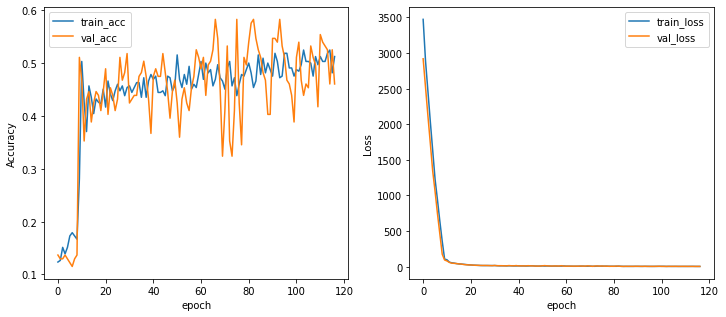

In [ ]:
model3 = Net([11+3+2, 64], 4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import torch.optim as optim
num_epochs = 200
learning_rate = 3e-4

#criterion = nn.CrossEntropyLoss(reduction='sum')
criterion = FocalLoss()
adam_optimizer = optim.Adam(model3.parameters(), lr=learning_rate)

#loss_dict, best_model = train3(model3, criterion, adam_optimizer, num_epochs, save_name="model/exp2/model3.pt")
loss_dict, best_model = train3(model3, criterion, adam_optimizer, num_epochs, save_name=False)


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(loss_dict["train_acc"], label="train_acc")
plt.plot(loss_dict["val_acc"], label="val_acc")
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.subplot(1,2,2)
plt.plot(loss_dict["train_loss"], label="train_loss")
plt.plot(loss_dict["val_loss"], label="val_loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

3. Validation 재현

In [ ]:
model3 = Net([11+3+2, 64], 4)
model3.load_state_dict(torch.load("model/exp2/model3.pt"))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with torch.no_grad():
  model3 = model3.to(device)
  model3.eval()

  test_loss = 0.
  test_acc = 0.
  preds = []
  labels_list = []
  for batch_X in tqdm(val_dataloader):
    aws = batch_X['aws'].to(device)
    geo = batch_X['geo'].to(device)
    social = batch_X['social'].to(device)
    inputs = torch.cat((aws,geo,social), -1)
    labels = batch_X['label'].to(device)
    
    # Forward Pass
    outputs = model3(inputs)
    preds.append(torch.argmax(outputs, -1))
    labels_list.append(labels)

print()
print()
print("-"*30)

preds = torch.cat(preds)
labels_list = torch.cat(labels_list)
accuracy = float(torch.sum(preds == labels_list) / len(preds)) * 100

print(f"\t1. Accuracy : {accuracy:.2f}%")
print()


idx = labels_list == 3
recall_3 = float(torch.sum(preds[idx]>1)/len(preds[idx])) * 100
print(f"\t2. Recall of Label 3 : {recall_3:.2f}%")
print()

preds[preds != 0] = 1
labels_list[labels_list != 0] = 1
acc_01 = float(torch.sum(preds==labels_list)/len(preds)) * 100
print(f"\t3. 0/1 Accuracy : {acc_01:.2f}%")

  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 5/5 [00:00<00:00, 17.12it/s]



------------------------------
	1. Accuracy : 46.04%

	2. Recall of Label 3 : 52.38%

	3. 0/1 Accuracy : 66.91%


# Case 2 : 기상,지형,사회경제 데이터를 순차적으로 사용하는 모델

1. [함수] 학습 코드

In [ ]:
def train2(model, Loss, optimizer, num_epochs, save_name=False):
  model = model.to(device)
  f1 = F1Score(num_classes=4)

  loss_dict = {"train_loss":[], "val_loss":[],
               "train_acc":[], "val_acc":[]}
  eval_every = 1
  
  best_test_acc = 0.
  #best_test_loss = np.inf
  early_stop, early_stop_max = 0., 50

  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=10, verbose=True)
  
  for epoch in range(num_epochs):

    epoch_loss = 0.
    epoch_acc = 0.
    for batch_X in tqdm(train_dataloader):
      aws = batch_X['aws'].to(device)
      geo = batch_X['geo'].to(device)
      social = batch_X['social'].to(device)
      labels = batch_X['label'].to(device)

      
      optimizer.zero_grad()
      model.train()

      # Forward Pass      
      outputs = model(aws, geo, social)
      train_loss = Loss(outputs, labels)
      epoch_loss += train_loss.item()
      epoch_acc += torch.sum(torch.argmax(outputs, -1) == labels)

      # Backward and optimize
      train_loss.backward()
      optimizer.step()

    epoch_loss /= len(train_dataloader.dataset)
    epoch_acc /= len(train_dataloader.dataset)
    loss_dict["train_loss"].append(epoch_loss)
    loss_dict["train_acc"].append(epoch_acc)

    if epoch % eval_every == 0:
      model.eval()

      test_loss = 0.
      test_acc = 0.
      for batch_X in tqdm(val_dataloader):
        aws = batch_X['aws'].to(device)
        geo = batch_X['geo'].to(device)
        social = batch_X['social'].to(device)
        labels = batch_X['label'].to(device)

        # Forward Pass
        outputs = model(aws, geo, social)
        batch_loss = Loss(outputs, labels)
        test_loss += batch_loss.item()
        test_acc += torch.sum(torch.argmax(outputs, -1) == labels)

      test_loss /= len(val_dataloader.dataset)
      test_acc /= len(val_dataloader.dataset)
      loss_dict["val_loss"].append(test_loss)
      loss_dict["val_acc"].append(test_acc)
      
      
      # scheduler
      scheduler.step(test_loss)

      
      if best_test_acc < test_acc:
        best_test_acc = test_acc
        early_stop = 0
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.8f}, Test Loss: {test_loss:.8f} *')
        best_model = copy.deepcopy(model)
        if save_name:
          torch.save(model.state_dict(), save_name)
      else:
        early_stop += 1
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.8f}, Test Loss: {test_loss:.8f}')
      print(f'\t\t Train acc: {epoch_acc:.8f}, Test acc: {test_acc:.8f}')
      

    if early_stop >= early_stop_max:
      break
    
  return loss_dict, best_model

2. [클래스] 모델 정의

In [5]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    # 11, 3, 2
    self.Net1 = Net([11, 32], 8)
    self.Net2 = Net([3+8, 32], 8)
    self.Net3 = Net([2+8, 16], 4)

  def forward(self, aws, geo, social):
    out = self.Net1(aws)
    out = self.Net2(torch.cat((out, geo), -1))
    out = self.Net3(torch.cat((out, social), -1))   
    return out


3. 학습 진행

  0%|          | 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 5/5 [00:00<00:00,  9.82it/s]


Epoch [1/200], Train Loss: 1216.18110412, Test Loss: 916.06107380 *
		 Train acc: 0.12345679, Test acc: 0.15107913


100%|██████████| 5/5 [00:00<00:00, 11.11it/s]


Epoch [2/200], Train Loss: 905.69444444, Test Loss: 637.22406138 *
		 Train acc: 0.12345679, Test acc: 0.15827338


100%|██████████| 5/5 [00:00<00:00,  9.49it/s]


Epoch [3/200], Train Loss: 660.31030010, Test Loss: 472.43633023 *
		 Train acc: 0.16358025, Test acc: 0.20863310


100%|██████████| 5/5 [00:00<00:00, 16.47it/s]


Epoch [4/200], Train Loss: 471.22668947, Test Loss: 298.31031679
		 Train acc: 0.13888890, Test acc: 0.20143884


100%|██████████| 5/5 [00:00<00:00, 16.20it/s]


Epoch [5/200], Train Loss: 279.36416475, Test Loss: 139.87462676 *
		 Train acc: 0.13271604, Test acc: 0.31654677


100%|██████████| 5/5 [00:00<00:00, 16.54it/s]


Epoch [6/200], Train Loss: 157.63931406, Test Loss: 114.72176575 *
		 Train acc: 0.40123457, Test acc: 0.49640289


100%|██████████| 5/5 [00:00<00:00, 15.51it/s]


Epoch [7/200], Train Loss: 121.92177798, Test Loss: 78.88627350
		 Train acc: 0.45061728, Test acc: 0.38848922


100%|██████████| 5/5 [00:00<00:00, 14.17it/s]


Epoch [8/200], Train Loss: 70.21956041, Test Loss: 50.66122063
		 Train acc: 0.41358024, Test acc: 0.35251799


100%|██████████| 5/5 [00:00<00:00, 14.13it/s]


Epoch [9/200], Train Loss: 50.02173671, Test Loss: 51.62937389
		 Train acc: 0.27777779, Test acc: 0.32374102


100%|██████████| 5/5 [00:00<00:00, 14.09it/s]


Epoch [10/200], Train Loss: 46.05363276, Test Loss: 46.04003599
		 Train acc: 0.37345678, Test acc: 0.35971224


100%|██████████| 5/5 [00:00<00:00, 13.25it/s]


Epoch [11/200], Train Loss: 43.46010896, Test Loss: 45.46307812
		 Train acc: 0.36728394, Test acc: 0.30215827


100%|██████████| 5/5 [00:00<00:00, 14.37it/s]


Epoch [12/200], Train Loss: 41.01457167, Test Loss: 42.27684581
		 Train acc: 0.34259260, Test acc: 0.35971224


100%|██████████| 5/5 [00:00<00:00, 14.08it/s]


Epoch [13/200], Train Loss: 38.98191179, Test Loss: 40.61203179
		 Train acc: 0.36111110, Test acc: 0.35971224


100%|██████████| 5/5 [00:00<00:00, 14.13it/s]


Epoch [14/200], Train Loss: 36.93107680, Test Loss: 37.49622702
		 Train acc: 0.34876543, Test acc: 0.35971224


100%|██████████| 5/5 [00:00<00:00, 13.44it/s]


Epoch [15/200], Train Loss: 34.38368644, Test Loss: 36.10682448
		 Train acc: 0.37037036, Test acc: 0.36690646


100%|██████████| 5/5 [00:00<00:00, 14.19it/s]


Epoch [16/200], Train Loss: 32.22977551, Test Loss: 35.47156398
		 Train acc: 0.36728394, Test acc: 0.33093524


100%|██████████| 5/5 [00:00<00:00, 13.85it/s]


Epoch [17/200], Train Loss: 30.42450865, Test Loss: 32.15449074
		 Train acc: 0.35185185, Test acc: 0.32374102


100%|██████████| 5/5 [00:00<00:00, 15.54it/s]


Epoch [18/200], Train Loss: 27.96662747, Test Loss: 31.25716329
		 Train acc: 0.36728394, Test acc: 0.26618704


100%|██████████| 5/5 [00:00<00:00, 14.46it/s]


Epoch [19/200], Train Loss: 25.76488509, Test Loss: 28.74400604
		 Train acc: 0.37037036, Test acc: 0.28776979


100%|██████████| 5/5 [00:00<00:00, 14.10it/s]


Epoch [20/200], Train Loss: 24.05792057, Test Loss: 26.06463711
		 Train acc: 0.35185185, Test acc: 0.35971224


100%|██████████| 5/5 [00:00<00:00, 13.23it/s]


Epoch [21/200], Train Loss: 21.81563313, Test Loss: 25.72283826
		 Train acc: 0.39814815, Test acc: 0.30215827


100%|██████████| 5/5 [00:00<00:00, 15.52it/s]


Epoch [22/200], Train Loss: 20.33911704, Test Loss: 23.82137249
		 Train acc: 0.37962964, Test acc: 0.35971224


100%|██████████| 5/5 [00:00<00:00, 13.93it/s]


Epoch [23/200], Train Loss: 19.65386869, Test Loss: 22.54714527
		 Train acc: 0.37037036, Test acc: 0.38129497


100%|██████████| 5/5 [00:00<00:00, 15.73it/s]


Epoch [24/200], Train Loss: 17.61378196, Test Loss: 22.31241789
		 Train acc: 0.41049382, Test acc: 0.38129497


100%|██████████| 5/5 [00:00<00:00, 16.01it/s]


Epoch [25/200], Train Loss: 16.82157388, Test Loss: 23.77407727
		 Train acc: 0.41666666, Test acc: 0.15107913


100%|██████████| 5/5 [00:00<00:00, 15.21it/s]


Epoch [26/200], Train Loss: 20.67613824, Test Loss: 19.45818148
		 Train acc: 0.38888890, Test acc: 0.37410071


100%|██████████| 5/5 [00:00<00:00, 14.48it/s]


Epoch [27/200], Train Loss: 15.79655840, Test Loss: 19.76114243
		 Train acc: 0.34876543, Test acc: 0.18705036


100%|██████████| 5/5 [00:00<00:00, 13.03it/s]


Epoch [28/200], Train Loss: 14.14735427, Test Loss: 16.42234627
		 Train acc: 0.44135803, Test acc: 0.31654677


100%|██████████| 5/5 [00:00<00:00, 15.52it/s]


Epoch [29/200], Train Loss: 13.77046411, Test Loss: 15.68399586
		 Train acc: 0.40740740, Test acc: 0.43884891


100%|██████████| 5/5 [00:00<00:00, 15.67it/s]


Epoch [30/200], Train Loss: 13.21380686, Test Loss: 14.56167482
		 Train acc: 0.40432099, Test acc: 0.46762589


100%|██████████| 5/5 [00:00<00:00, 16.16it/s]


Epoch [31/200], Train Loss: 14.09280403, Test Loss: 14.45223406
		 Train acc: 0.38888890, Test acc: 0.31654677


100%|██████████| 5/5 [00:00<00:00, 15.04it/s]


Epoch [32/200], Train Loss: 11.04556206, Test Loss: 11.76322421
		 Train acc: 0.41358024, Test acc: 0.41007194


100%|██████████| 5/5 [00:00<00:00, 13.86it/s]


Epoch [33/200], Train Loss: 10.12358427, Test Loss: 11.18091973
		 Train acc: 0.41975307, Test acc: 0.37410071


100%|██████████| 5/5 [00:00<00:00, 15.26it/s]


Epoch [34/200], Train Loss: 9.05675540, Test Loss: 10.29628990
		 Train acc: 0.36419752, Test acc: 0.32374102


100%|██████████| 5/5 [00:00<00:00, 15.77it/s]


Epoch [35/200], Train Loss: 7.88296229, Test Loss: 9.27838294
		 Train acc: 0.41358024, Test acc: 0.40287769


100%|██████████| 5/5 [00:00<00:00, 15.71it/s]


Epoch [36/200], Train Loss: 7.47055107, Test Loss: 8.45573815
		 Train acc: 0.41049382, Test acc: 0.38129497


100%|██████████| 5/5 [00:00<00:00, 15.91it/s]


Epoch [37/200], Train Loss: 6.41186884, Test Loss: 7.83610853
		 Train acc: 0.41049382, Test acc: 0.26618704


100%|██████████| 5/5 [00:00<00:00, 16.20it/s]


Epoch [38/200], Train Loss: 6.28461224, Test Loss: 7.01607634
		 Train acc: 0.40740740, Test acc: 0.28776979


100%|██████████| 5/5 [00:00<00:00, 13.26it/s]


Epoch [39/200], Train Loss: 5.18541729, Test Loss: 8.68822101
		 Train acc: 0.35185185, Test acc: 0.17266187


100%|██████████| 5/5 [00:00<00:00, 13.03it/s]


Epoch [40/200], Train Loss: 5.95822098, Test Loss: 4.88702862
		 Train acc: 0.36111110, Test acc: 0.46762589


100%|██████████| 5/5 [00:00<00:00, 14.18it/s]


Epoch [41/200], Train Loss: 4.25196919, Test Loss: 3.16492575 *
		 Train acc: 0.36419752, Test acc: 0.50359714


100%|██████████| 5/5 [00:00<00:00, 15.99it/s]


Epoch [42/200], Train Loss: 3.66328708, Test Loss: 3.61818267 *
		 Train acc: 0.37654322, Test acc: 0.53956836


100%|██████████| 5/5 [00:00<00:00, 15.19it/s]


Epoch [43/200], Train Loss: 5.28039824, Test Loss: 7.55088351
		 Train acc: 0.37037036, Test acc: 0.37410071


100%|██████████| 5/5 [00:00<00:00, 16.02it/s]


Epoch [44/200], Train Loss: 5.91261952, Test Loss: 3.92566492
		 Train acc: 0.38580248, Test acc: 0.53237408


100%|██████████| 5/5 [00:00<00:00, 13.40it/s]


Epoch [45/200], Train Loss: 3.49733389, Test Loss: 2.87019941
		 Train acc: 0.40123457, Test acc: 0.38129497


100%|██████████| 5/5 [00:00<00:00, 13.42it/s]


Epoch [46/200], Train Loss: 2.68621651, Test Loss: 2.42078682
		 Train acc: 0.36419752, Test acc: 0.23021583


100%|██████████| 5/5 [00:00<00:00, 13.02it/s]


Epoch [47/200], Train Loss: 2.51504652, Test Loss: 2.82352239
		 Train acc: 0.41358024, Test acc: 0.25899279


100%|██████████| 5/5 [00:00<00:00, 12.97it/s]


Epoch [48/200], Train Loss: 3.80921428, Test Loss: 6.13822838
		 Train acc: 0.34876543, Test acc: 0.18705036


100%|██████████| 5/5 [00:00<00:00, 11.11it/s]


Epoch [49/200], Train Loss: 5.01126216, Test Loss: 6.00642818
		 Train acc: 0.38580248, Test acc: 0.53237408


100%|██████████| 5/5 [00:00<00:00,  8.33it/s]


Epoch [50/200], Train Loss: 3.88147714, Test Loss: 3.03668040 *
		 Train acc: 0.41049382, Test acc: 0.55395681


100%|██████████| 5/5 [00:00<00:00,  6.48it/s]


Epoch [51/200], Train Loss: 2.46977980, Test Loss: 1.87283915 *
		 Train acc: 0.45061728, Test acc: 0.58273381


100%|██████████| 5/5 [00:00<00:00, 14.55it/s]


Epoch [52/200], Train Loss: 2.58978226, Test Loss: 0.92756520
		 Train acc: 0.42901236, Test acc: 0.36690646


100%|██████████| 5/5 [00:00<00:00, 15.41it/s]


Epoch [53/200], Train Loss: 3.21400195, Test Loss: 4.64500570
		 Train acc: 0.36111110, Test acc: 0.53237408


100%|██████████| 5/5 [00:00<00:00, 14.34it/s]


Epoch [54/200], Train Loss: 3.23086401, Test Loss: 1.99193878
		 Train acc: 0.39814815, Test acc: 0.56115109


100%|██████████| 5/5 [00:00<00:00, 14.99it/s]


Epoch [55/200], Train Loss: 1.86552852, Test Loss: 3.90554170
		 Train acc: 0.42901236, Test acc: 0.18705036


100%|██████████| 5/5 [00:00<00:00, 13.81it/s]


Epoch [56/200], Train Loss: 3.77981402, Test Loss: 6.70655680
		 Train acc: 0.33950618, Test acc: 0.53237408


100%|██████████| 5/5 [00:00<00:00, 13.07it/s]


Epoch [57/200], Train Loss: 6.04011884, Test Loss: 12.15682023
		 Train acc: 0.44135803, Test acc: 0.19424461


100%|██████████| 5/5 [00:00<00:00, 15.26it/s]


Epoch [58/200], Train Loss: 9.74715911, Test Loss: 11.24534365
		 Train acc: 0.32098764, Test acc: 0.53237408


100%|██████████| 5/5 [00:00<00:00, 13.42it/s]


Epoch [59/200], Train Loss: 8.66351681, Test Loss: 11.26912640
		 Train acc: 0.34876543, Test acc: 0.53237408


100%|██████████| 5/5 [00:00<00:00, 13.48it/s]


Epoch [60/200], Train Loss: 7.55406759, Test Loss: 7.27934441
		 Train acc: 0.39506173, Test acc: 0.53237408


100%|██████████| 5/5 [00:00<00:00, 12.78it/s]


Epoch [61/200], Train Loss: 5.37282788, Test Loss: 4.91120290
		 Train acc: 0.34876543, Test acc: 0.56834531


100%|██████████| 5/5 [00:00<00:00, 14.47it/s]


Epoch [62/200], Train Loss: 3.38907412, Test Loss: 1.03386629
		 Train acc: 0.44135803, Test acc: 0.51798558


100%|██████████| 5/5 [00:00<00:00,  9.58it/s]


Epoch 00063: reducing learning rate of group 0 to 9.0000e-05.
Epoch [63/200], Train Loss: 1.35694841, Test Loss: 1.77013167
		 Train acc: 0.47222221, Test acc: 0.54676259


100%|██████████| 5/5 [00:00<00:00,  8.46it/s]


Epoch [64/200], Train Loss: 1.22096551, Test Loss: 1.08545457
		 Train acc: 0.46913579, Test acc: 0.56115109


100%|██████████| 5/5 [00:00<00:00, 14.39it/s]


Epoch [65/200], Train Loss: 1.02472971, Test Loss: 1.01099320
		 Train acc: 0.48456791, Test acc: 0.53956836


100%|██████████| 5/5 [00:00<00:00, 14.86it/s]


Epoch [66/200], Train Loss: 1.21265752, Test Loss: 0.95755866
		 Train acc: 0.45679012, Test acc: 0.39568347


100%|██████████| 5/5 [00:00<00:00, 14.05it/s]


Epoch [67/200], Train Loss: 0.98103559, Test Loss: 0.64341501
		 Train acc: 0.46604937, Test acc: 0.54676259


100%|██████████| 5/5 [00:00<00:00, 13.90it/s]


Epoch [68/200], Train Loss: 0.69386255, Test Loss: 0.62379499
		 Train acc: 0.50617284, Test acc: 0.57553959


100%|██████████| 5/5 [00:00<00:00, 14.24it/s]


Epoch [69/200], Train Loss: 0.73738819, Test Loss: 0.79743100
		 Train acc: 0.50308645, Test acc: 0.43165466


100%|██████████| 5/5 [00:00<00:00, 13.81it/s]


Epoch [70/200], Train Loss: 0.75913896, Test Loss: 0.94122081 *
		 Train acc: 0.50925928, Test acc: 0.59712231


100%|██████████| 5/5 [00:00<00:00, 14.27it/s]


Epoch [71/200], Train Loss: 0.86701671, Test Loss: 0.78046964
		 Train acc: 0.47839507, Test acc: 0.49640289


100%|██████████| 5/5 [00:00<00:00, 12.84it/s]


Epoch [72/200], Train Loss: 0.70381441, Test Loss: 0.71984720
		 Train acc: 0.48148149, Test acc: 0.56834531


100%|██████████| 5/5 [00:00<00:00, 14.75it/s]


Epoch [73/200], Train Loss: 0.64853322, Test Loss: 0.59209094
		 Train acc: 0.51851851, Test acc: 0.56115109


100%|██████████| 5/5 [00:00<00:00, 13.85it/s]


Epoch [74/200], Train Loss: 0.71688682, Test Loss: 1.03456667
		 Train acc: 0.48765433, Test acc: 0.28057554


100%|██████████| 5/5 [00:00<00:00, 14.27it/s]


Epoch [75/200], Train Loss: 0.94005587, Test Loss: 0.99870627 *
		 Train acc: 0.43518519, Test acc: 0.60431653


100%|██████████| 5/5 [00:00<00:00, 15.22it/s]


Epoch [76/200], Train Loss: 1.15719574, Test Loss: 0.81358348
		 Train acc: 0.46296296, Test acc: 0.59712231


100%|██████████| 5/5 [00:00<00:00, 13.25it/s]


Epoch [77/200], Train Loss: 0.83146034, Test Loss: 0.72454366
		 Train acc: 0.49382716, Test acc: 0.48920864


100%|██████████| 5/5 [00:00<00:00, 15.27it/s]


Epoch [78/200], Train Loss: 0.66732008, Test Loss: 0.74469391
		 Train acc: 0.51234567, Test acc: 0.53237408


100%|██████████| 5/5 [00:00<00:00, 14.40it/s]


Epoch [79/200], Train Loss: 0.73826824, Test Loss: 0.61778270 *
		 Train acc: 0.50925928, Test acc: 0.61870503


100%|██████████| 5/5 [00:00<00:00, 14.96it/s]


Epoch [80/200], Train Loss: 0.79483488, Test Loss: 0.66666653
		 Train acc: 0.52160496, Test acc: 0.53956836


100%|██████████| 5/5 [00:00<00:00, 12.79it/s]


Epoch [81/200], Train Loss: 0.74708698, Test Loss: 0.79896659
		 Train acc: 0.47839507, Test acc: 0.61151081


100%|██████████| 5/5 [00:00<00:00, 14.63it/s]


Epoch [82/200], Train Loss: 0.75723356, Test Loss: 0.83561999
		 Train acc: 0.51543212, Test acc: 0.52517986


100%|██████████| 5/5 [00:00<00:00, 12.35it/s]


Epoch [83/200], Train Loss: 0.82152684, Test Loss: 0.80075775
		 Train acc: 0.46604937, Test acc: 0.53237408


100%|██████████| 5/5 [00:00<00:00, 14.28it/s]


Epoch 00084: reducing learning rate of group 0 to 2.7000e-05.
Epoch [84/200], Train Loss: 0.72384390, Test Loss: 0.85793498
		 Train acc: 0.54629630, Test acc: 0.56834531


100%|██████████| 5/5 [00:00<00:00, 13.39it/s]


Epoch [85/200], Train Loss: 0.72544051, Test Loss: 0.61834359
		 Train acc: 0.49382716, Test acc: 0.56115109


100%|██████████| 5/5 [00:00<00:00, 14.44it/s]


Epoch [86/200], Train Loss: 0.64601543, Test Loss: 0.66316381
		 Train acc: 0.54938269, Test acc: 0.55395681


100%|██████████| 5/5 [00:00<00:00, 14.06it/s]


Epoch [87/200], Train Loss: 0.61521402, Test Loss: 0.57638778
		 Train acc: 0.51851851, Test acc: 0.60431653


100%|██████████| 5/5 [00:00<00:00, 14.52it/s]


Epoch [88/200], Train Loss: 0.64701898, Test Loss: 0.66255936
		 Train acc: 0.48765433, Test acc: 0.56115109


100%|██████████| 5/5 [00:00<00:00, 14.69it/s]


Epoch [89/200], Train Loss: 0.67452644, Test Loss: 0.65712603
		 Train acc: 0.46913579, Test acc: 0.58273381


100%|██████████| 5/5 [00:00<00:00, 11.75it/s]


Epoch [90/200], Train Loss: 0.63694210, Test Loss: 0.63019744
		 Train acc: 0.52160496, Test acc: 0.56834531


100%|██████████| 5/5 [00:00<00:00, 12.32it/s]


Epoch [91/200], Train Loss: 0.61496113, Test Loss: 0.62706937
		 Train acc: 0.53086418, Test acc: 0.53956836


100%|██████████| 5/5 [00:00<00:00, 11.95it/s]


Epoch [92/200], Train Loss: 0.62252391, Test Loss: 0.62779720
		 Train acc: 0.53703701, Test acc: 0.51798558


100%|██████████| 5/5 [00:00<00:00, 12.61it/s]


Epoch [93/200], Train Loss: 0.60853092, Test Loss: 0.62844349
		 Train acc: 0.52777779, Test acc: 0.54676259


100%|██████████| 5/5 [00:00<00:00, 13.75it/s]


Epoch [94/200], Train Loss: 0.60021822, Test Loss: 0.63756795
		 Train acc: 0.52469134, Test acc: 0.60431653


100%|██████████| 5/5 [00:00<00:00, 11.69it/s]


Epoch [95/200], Train Loss: 0.60363625, Test Loss: 0.61016039
		 Train acc: 0.53395063, Test acc: 0.61870503


100%|██████████| 5/5 [00:00<00:00, 12.63it/s]


Epoch [96/200], Train Loss: 0.59729995, Test Loss: 0.60906868
		 Train acc: 0.50925928, Test acc: 0.61870503


100%|██████████| 5/5 [00:00<00:00, 13.91it/s]


Epoch [97/200], Train Loss: 0.62245233, Test Loss: 0.62566733
		 Train acc: 0.52160496, Test acc: 0.53956836


100%|██████████| 5/5 [00:00<00:00, 13.65it/s]


Epoch 00098: reducing learning rate of group 0 to 8.1000e-06.
Epoch [98/200], Train Loss: 0.61454605, Test Loss: 0.59085231
		 Train acc: 0.52469134, Test acc: 0.57553959


100%|██████████| 5/5 [00:00<00:00, 13.73it/s]


Epoch [99/200], Train Loss: 0.59037497, Test Loss: 0.59943882
		 Train acc: 0.54629630, Test acc: 0.58273381


100%|██████████| 5/5 [00:00<00:00, 11.74it/s]


Epoch [100/200], Train Loss: 0.58188604, Test Loss: 0.60265517
		 Train acc: 0.54320985, Test acc: 0.58273381


100%|██████████| 5/5 [00:00<00:00, 12.67it/s]


Epoch [101/200], Train Loss: 0.58698716, Test Loss: 0.59582596
		 Train acc: 0.52160496, Test acc: 0.59712231


100%|██████████| 5/5 [00:00<00:00, 13.69it/s]


Epoch [102/200], Train Loss: 0.58569047, Test Loss: 0.59320906
		 Train acc: 0.53395063, Test acc: 0.58273381


100%|██████████| 5/5 [00:00<00:00, 11.61it/s]


Epoch [103/200], Train Loss: 0.58258957, Test Loss: 0.60904743
		 Train acc: 0.52469134, Test acc: 0.58992803


100%|██████████| 5/5 [00:00<00:00, 12.99it/s]


Epoch [104/200], Train Loss: 0.57966514, Test Loss: 0.59567916
		 Train acc: 0.55555558, Test acc: 0.57553959


100%|██████████| 5/5 [00:00<00:00, 13.29it/s]


Epoch [105/200], Train Loss: 0.58114453, Test Loss: 0.58837478
		 Train acc: 0.52160496, Test acc: 0.58992803


100%|██████████| 5/5 [00:00<00:00, 14.56it/s]


Epoch [106/200], Train Loss: 0.58885334, Test Loss: 0.59866063
		 Train acc: 0.54012346, Test acc: 0.57553959


100%|██████████| 5/5 [00:00<00:00, 11.89it/s]


Epoch [107/200], Train Loss: 0.58587056, Test Loss: 0.59519955
		 Train acc: 0.52777779, Test acc: 0.59712231


100%|██████████| 5/5 [00:00<00:00, 12.08it/s]


Epoch [108/200], Train Loss: 0.61008087, Test Loss: 0.60589981
		 Train acc: 0.50925928, Test acc: 0.59712231


100%|██████████| 5/5 [00:00<00:00, 12.32it/s]


Epoch 00109: reducing learning rate of group 0 to 2.4300e-06.
Epoch [109/200], Train Loss: 0.59677653, Test Loss: 0.59633094
		 Train acc: 0.52469134, Test acc: 0.58992803


100%|██████████| 5/5 [00:00<00:00, 12.09it/s]


Epoch [110/200], Train Loss: 0.57946295, Test Loss: 0.59207989
		 Train acc: 0.54629630, Test acc: 0.57553959


100%|██████████| 5/5 [00:00<00:00, 13.02it/s]


Epoch [111/200], Train Loss: 0.57637928, Test Loss: 0.59751479
		 Train acc: 0.53395063, Test acc: 0.58273381


100%|██████████| 5/5 [00:00<00:00, 14.01it/s]


Epoch [112/200], Train Loss: 0.57552081, Test Loss: 0.59291927
		 Train acc: 0.53086418, Test acc: 0.59712231


100%|██████████| 5/5 [00:00<00:00, 13.98it/s]


Epoch [113/200], Train Loss: 0.57312320, Test Loss: 0.59020218
		 Train acc: 0.54320985, Test acc: 0.58273381


100%|██████████| 5/5 [00:00<00:00, 12.57it/s]


Epoch [114/200], Train Loss: 0.57523949, Test Loss: 0.59200497
		 Train acc: 0.53395063, Test acc: 0.58273381


100%|██████████| 5/5 [00:00<00:00, 12.80it/s]


Epoch [115/200], Train Loss: 0.57386303, Test Loss: 0.59944078
		 Train acc: 0.54938269, Test acc: 0.58992803


100%|██████████| 5/5 [00:00<00:00, 14.21it/s]


Epoch [116/200], Train Loss: 0.57419399, Test Loss: 0.59677321
		 Train acc: 0.54012346, Test acc: 0.59712231


100%|██████████| 5/5 [00:00<00:00, 12.13it/s]


Epoch [117/200], Train Loss: 0.57735798, Test Loss: 0.59277133
		 Train acc: 0.54012346, Test acc: 0.58273381


100%|██████████| 5/5 [00:00<00:00, 13.91it/s]


Epoch [118/200], Train Loss: 0.57381352, Test Loss: 0.59729217
		 Train acc: 0.52469134, Test acc: 0.58992803


100%|██████████| 5/5 [00:00<00:00, 14.19it/s]


Epoch [119/200], Train Loss: 0.57508438, Test Loss: 0.59815579
		 Train acc: 0.54320985, Test acc: 0.59712231


100%|██████████| 5/5 [00:00<00:00, 12.42it/s]


Epoch 00120: reducing learning rate of group 0 to 7.2900e-07.
Epoch [120/200], Train Loss: 0.57418288, Test Loss: 0.59143381
		 Train acc: 0.54938269, Test acc: 0.59712231


100%|██████████| 5/5 [00:00<00:00, 13.66it/s]


Epoch [121/200], Train Loss: 0.57347423, Test Loss: 0.59007134
		 Train acc: 0.52469134, Test acc: 0.58992803


100%|██████████| 5/5 [00:00<00:00, 12.19it/s]


Epoch [122/200], Train Loss: 0.57297889, Test Loss: 0.59264561
		 Train acc: 0.52777779, Test acc: 0.58992803


100%|██████████| 5/5 [00:00<00:00, 11.93it/s]


Epoch [123/200], Train Loss: 0.57377968, Test Loss: 0.59484758
		 Train acc: 0.54629630, Test acc: 0.58273381


100%|██████████| 5/5 [00:00<00:00, 13.84it/s]


Epoch [124/200], Train Loss: 0.57278916, Test Loss: 0.59421854
		 Train acc: 0.54320985, Test acc: 0.59712231


100%|██████████| 5/5 [00:00<00:00, 11.93it/s]


Epoch [125/200], Train Loss: 0.57284925, Test Loss: 0.59423675
		 Train acc: 0.54938269, Test acc: 0.59712231


100%|██████████| 5/5 [00:00<00:00, 14.10it/s]


Epoch [126/200], Train Loss: 0.57269977, Test Loss: 0.59434940
		 Train acc: 0.53703701, Test acc: 0.58992803


100%|██████████| 5/5 [00:00<00:00, 14.31it/s]


Epoch [127/200], Train Loss: 0.57284741, Test Loss: 0.59534911
		 Train acc: 0.54012346, Test acc: 0.58992803


100%|██████████| 5/5 [00:00<00:00, 13.37it/s]


Epoch [128/200], Train Loss: 0.57296642, Test Loss: 0.59470939
		 Train acc: 0.54012346, Test acc: 0.58273381


100%|██████████| 5/5 [00:00<00:00, 11.66it/s]


Epoch [129/200], Train Loss: 0.57346225, Test Loss: 0.59493366
		 Train acc: 0.54012346, Test acc: 0.59712231


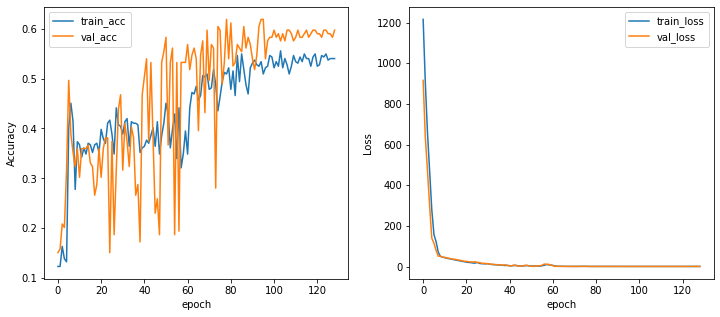

In [ ]:
model2 = Model()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import torch.optim as optim
num_epochs = 200
learning_rate = 3e-4

#criterion = nn.CrossEntropyLoss(reduction='sum')
criterion = FocalLoss()
adam_optimizer = optim.Adam(model2.parameters(), lr=learning_rate)

#loss_dict, best_model = train2(model2, criterion, adam_optimizer, num_epochs, save_name="model/exp2/model2.pt")
loss_dict, best_model = train2(model2, criterion, adam_optimizer, num_epochs, save_name=False)


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(loss_dict["train_acc"], label="train_acc")
plt.plot(loss_dict["val_acc"], label="val_acc")
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.subplot(1,2,2)
plt.plot(loss_dict["train_loss"], label="train_loss")
plt.plot(loss_dict["val_loss"], label="val_loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

4. Validation 재현

In [ ]:
model2 = Model()
model2.load_state_dict(torch.load("model/exp2/model2.pt"))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with torch.no_grad():
  model2 = model2.to(device)
  model2.eval()

  test_loss = 0.
  test_acc = 0.
  preds = []
  labels_list = []
  for batch_X in tqdm(val_dataloader):
    aws = batch_X['aws'].to(device)
    geo = batch_X['geo'].to(device)
    social = batch_X['social'].to(device)
    labels = batch_X['label'].to(device)

    # Forward Pass
    outputs = model2(aws, geo, social)
    preds.append(torch.argmax(outputs, -1))
    labels_list.append(labels)

print()
print()
print("-"*30)

preds = torch.cat(preds)
labels_list = torch.cat(labels_list)
accuracy = float(torch.sum(preds == labels_list) / len(preds)) * 100

print(f"\t1. Accuracy : {accuracy:.2f}%")
print()


idx = labels_list == 3
recall_3 = float(torch.sum(preds[idx]>1)/len(preds[idx])) * 100
print(f"\t2. Recall of Label 3 : {recall_3:.2f}%")
print()

preds[preds != 0] = 1
labels_list[labels_list != 0] = 1
acc_01 = float(torch.sum(preds==labels_list)/len(preds)) * 100
print(f"\t3. 0/1 Accuracy : {acc_01:.2f}%")

100%|██████████| 5/5 [00:00<00:00, 11.49it/s]



------------------------------
	1. Accuracy : 61.87%

	2. Recall of Label 3 : 66.67%

	3. 0/1 Accuracy : 68.35%


5. 2022년 관악구...

In [16]:
df_kwanak = pd.read_csv('aws_edit/df_train_aws_관악_2022.csv').drop(columns=["Unnamed: 0"])
df_kwanak

,지점명,일시,일강수량_sum_mm,일강수량_mean_mm,일강수량_std_mm,일강수량_max_mm,평균기온_mean_c,평균풍속_mean_ms,최저기온_min_c,최고기온_max_c,최대순간풍속_max_ms,최대순간풍속향_max_deg,집중호우일수
0,관악,2022,1491.5,16.211957,45.069131,305.5,23.632609,1.747826,13.0,34.5,10.7,354.4,5


In [17]:
seq_list = df_kwanak.squeeze().iloc[2:]
seq_list

일강수량_sum_mm           1491.5
일강수량_mean_mm       16.211957
일강수량_std_mm        45.069131
일강수량_max_mm            305.5
평균기온_mean_c        23.632609
평균풍속_mean_ms        1.747826
최저기온_min_c              13.0
최고기온_max_c              34.5
최대순간풍속_max_ms           10.7
최대순간풍속향_max_deg        354.4
집중호우일수                     5
Name: 0, dtype: object

In [27]:
# 전처리된 기상 데이터 (2022년 관악구 AWS) 를 불러와서 사용한다.
aws = []
for word in seq_list.to_string(header=False, index=False).split("\n"):
  word = word.strip()
  aws.append(word)
print("aws features :", aws)

# 지형, 사회경제 데이터는 연도와 상관없이 동일하기에, 2020년 관악구 데이터를 불러와서 사용한다.
with open("dataset/exp2/4_2020.txt", "r") as f:
  txt_data = f.readline().split("\t")
  geo = txt_data[-5:-2]
  social = txt_data[-2:]
print("geo features :", geo)
print("social features :", social)

aws features : ['1491.5', '16.211957', '45.069131', '305.5', '23.632609', '1.747826', '13.0', '34.5', '10.7', '354.4', '5']
geo features : ['29.5693556', '1744.0', '2']
social features : ['11369', '24909']


In [30]:
model2 = Model()
model2.load_state_dict(torch.load("model/exp2/model2.pt"))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def _to_float_tensor(L: list):
  temp = []
  for word in L:
    temp.append(float(word))
  return torch.tensor(temp)


with torch.no_grad():
  model2 = model2.to(device)
  model2.eval()

  aws = _to_float_tensor(aws).to(device)
  geo = _to_float_tensor(geo).to(device)
  social = _to_float_tensor(social).to(device)

  # Forward Pass
  outputs = model2(aws, geo, social)
  print("예측한 Label 값 :", int(torch.argmax(outputs, -1)))



예측한 Label 값 : 3
